In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import threading
import os
import time

# 设置设备（如果有GPU则使用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class vMFMixtureModel(nn.Module):
    def __init__(self, num_components):
        super(vMFMixtureModel, self).__init__()
        self.num_components = num_components

        # 混合系数的对数几率
        self.w_logits = nn.Parameter(torch.randn(num_components))

        # 角度参数 theta 和 phi
        self.theta_phi = nn.Parameter(torch.randn(2 * num_components)*3)

        # 浓度参数的对数
        self.log_kappa = nn.Parameter(torch.randn(num_components))

    def forward(self):
        # 计算混合系数
        weight = F.softmax(self.w_logits, dim=0)

        # 使用 sigmoid 将 theta 和 phi 限制在 [0,1]
        theta_phi = torch.sigmoid(self.theta_phi)

        # 映射到实际角度范围
        theta = theta_phi[:self.num_components] * math.pi          # [0, π]
        phi = theta_phi[self.num_components:] * 2 * math.pi        # [0, 2π]

        # 计算球坐标系下的 μ
        cos_theta = torch.cos(theta)
        sin_theta = torch.sin(theta)
        cos_phi = torch.cos(phi)
        sin_phi = torch.sin(phi)
        mu = torch.stack((sin_theta * cos_phi, sin_theta * sin_phi, cos_theta), dim=1)  # Shape: (num_components, 3)

        # 计算浓度参数
        kappa = torch.exp(self.log_kappa)
        # kappa = torch.clamp(kappa, min=1e-10, max=1e5)  # 限制 kappa 的最大值，防止数值不稳定

        return weight, mu, kappa
    
    

def negative_log_likelihood(raw_data, weight, mu, kappa, **kwargs):

    kl_lambda = kwargs['kl_lambda']
    l1_lambda = kwargs['l1_lambda']
    l2_lambda = kwargs['l2_lambda']
    p = kwargs['p']
    w = kwargs['w']

    total_prob = multi_vmf(weight, mu, kappa, raw_data)
    if kl_lambda > 0:
        nll = -torch.log(total_prob + 1e-10).mean()
    else:
        nll = torch.tensor(0.0)

    q = multi_vmf(weight, mu, kappa, w)
    if l1_lambda > 0:
        rec_loss = torch.abs(q - p).mean()
    else:
        rec_loss = torch.tensor(0.0)

    if l2_lambda > 0:
        l2_loss = torch.norm(q - p, p=2).mean()
    else:
        l2_loss = torch.tensor(0.0)

    loss = kl_lambda * nll + l1_lambda * rec_loss + l2_lambda * l2_loss
    return loss, {'NLL': nll, 'Rec': rec_loss, 'L2': l2_loss}

# 多重 von Mises-Fisher 分布函数
def multi_vmf(weights, axes, kappas, w):
    # Ensure kappas are non-negative for stability
    kappas = torch.clamp(kappas, min=1e-10, max=1e5)

    # Define thresholds for approximations
    large_kappa_threshold = 1e5  # Threshold for considering kappa as "large"
    small_kappa_threshold = 1e-3  # Threshold for considering kappa as "small"

    # Approximate normalization constant for large and small kappa values


    norm_const = torch.where(
        kappas > large_kappa_threshold,
        kappas / (2 * math.pi),  # Approximation for large kappa
        kappas / (2 * math.pi * (1-torch.exp(-2*kappas)))
    )
    # norm_const = kappas / (4 * math.pi * (1-torch.exp(-2*kappas)))

    # Compute dot products between input w and the axes of the spheres (unit vectors)
    dot_products = torch.matmul(w, axes.transpose(0, 1))-1  # Shape: (data_sizes, num_spheres)

    # Compute the weighted von Mises-Fisher pdf values
    weighted_exps = weights * norm_const * torch.exp(kappas * dot_products)  # Shape: (data_sizes, num_spheres)
    q = torch.sum(weighted_exps, dim=-1)  # Shape: (data_sizes,)
    q = torch.clamp(q, min=1e-10, max=1e10)  # Further clamping to avoid extreme values
    return q

def smooth_curve(values, smoothing_factor=0.9):
    smoothed_values = []
    last = values[0]
    for value in values:
        smoothed_value = last * smoothing_factor + (1 - smoothing_factor) * value
        smoothed_values.append(smoothed_value)
        last = smoothed_value
    return smoothed_values

def plot_losses(train_losses, val_losses = None):
    train_losses_smoothed = smooth_curve(train_losses)
    if val_losses is not None:
        val_losses_smoothed = smooth_curve(val_losses)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_smoothed, label="Training Loss (Smoothed)", color="blue")
    if val_losses is not None:
        plt.plot(val_losses_smoothed, label="Validation Loss (Smoothed)", color="red")
    plt.yscale("log")  # Log scale for the y-axis
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.title("Loss (Log Scale with Smoothing)")
    plt.legend()
    plt.show()

def plot_outputs_3d(references, predictions, sizes, save_path=None):
    # 定义 z 和 phi 的范围
    z_min, z_max = -1, 1
    phi_min, phi_max = -np.pi, np.pi

    # 创建用于 3D 绘图的网格
    z_in = np.linspace(z_min, z_max, sizes[0])
    phi_in = np.linspace(phi_min, phi_max, sizes[1])

    Z, Phi = np.meshgrid(z_in, phi_in, indexing='ij')

    target_img = references
    predict_img = predictions

    # 确保输入数据的形状与网格匹配
    if predict_img.shape != Z.shape:
        predict_img = predict_img.reshape(Z.shape)
    if target_img is not None and target_img.shape != Z.shape:
        target_img = target_img.reshape(Z.shape)

    # 设置用于 3D 可视化的子图
    if target_img is not None and np.sum(target_img) > 0:
        fig = plt.figure(figsize=(14, 6))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    else:
        fig = plt.figure(figsize=(10, 6))
        ax1 = fig.add_subplot(1, 1, 1, projection='3d')

    # 绘制预测数据的 3D 曲面
    ax1.plot_surface(Z, Phi, predict_img, rstride=1, cstride=1, cmap='rainbow')
    ax1.set_title('Prediction')
    ax1.set_xlabel('Z')
    ax1.set_ylabel('Phi')
    ax1.set_zlabel('Value')

    # 如果有参考数据，绘制其 3D 曲面
    if target_img is not None and np.sum(target_img) > 0:
        ax2.plot_surface(Z, Phi, target_img, rstride=1, cstride=1, cmap='rainbow')
        ax2.set_title('Reference')
        ax2.set_xlabel('Z')
        ax2.set_ylabel('Phi')
        ax2.set_zlabel('Value')

    # 显示图形
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()
    
def get_gridX(sizes):
    i_idx = torch.arange(sizes[0], dtype=torch.float, device=device) / sizes[0]
    j_idx = torch.arange(sizes[1], dtype=torch.float, device=device) / sizes[1]
    i_grid, j_grid = torch.meshgrid(i_idx, j_idx)
    pos_x = i_grid * 2 - 1
    pos_phi = (j_grid * 2 - 1) * np.pi
    pos_r = torch.sqrt(1 - pos_x**2)
    pos_y = pos_r * torch.cos(pos_phi)
    pos_z = pos_r * torch.sin(pos_phi)
    X = torch.stack((pos_x, pos_y, pos_z), dim=-1).reshape(-1, 3).to(device)
    return X   

# 加载 ray 数据的函数
def load_rawdata(filename, sizes, device, verbose=False):
    X = get_gridX(sizes)

    rawdata = np.fromfile(filename, dtype=np.float32)
    rawdata = rawdata.reshape(-1, 4)
    # print(rawdata.shape)
    x = rawdata[:,0]
    # print(np.max(data[:,1]))
    phi = rawdata[:,1]-np.pi
    r = np.sqrt(1 - x**2)
    y = r * np.cos(phi)
    z = r * np.sin(phi)


    # 创建网格分布
    x_edges = np.linspace(-1, 1, sizes[0]+1)  
    phi_edges = np.linspace(-np.pi, np.pi, sizes[1]+1)

    # 统计 (X, φ) 分布
    H, _, _ = np.histogram2d(x, phi, bins=[x_edges, phi_edges])
    ray_data = torch.tensor(H, dtype=torch.float32, device=device).reshape(-1, 1)
    if ray_data.shape[0] != sizes[0] * sizes[1]:
        print("Error: ray data shape mismatch!")
        exit(1)
    area = 4 * math.pi / (ray_data.shape[0])
    ray_data = ray_data / torch.sum(ray_data) / area
    

    raw_X = np.column_stack((x, y, z))
    raw_num = min(4096, raw_X.shape[0])
    raw_X = raw_X[:raw_num, :]

    # 将数据转换为张量
    raw_data = torch.tensor(raw_X, dtype=torch.float32, device=device)
    
    if verbose:
        print("X Mesh shape:", X.shape)
        print("ray data shape:", ray_data.shape)
        print("raw data shape:", raw_data.shape)
    return raw_data, ray_data, X

# 模型训练函数
def train_model(model_id, vmf, optimizer, dataset, hyperparams, device, save_path, cuda_stream = None, verbose=False):
    kl_lambda = hyperparams['kl_lambda']
    l1_lambda = hyperparams['l1_lambda']
    l2_lambda = hyperparams['l2_lambda']
    num_epochs = hyperparams['num_epochs']

    samples = dataset["samples"].to(device, non_blocking=True)
    target = dataset["target"].to(device, non_blocking=True)
    w_data = dataset["w_data"].to(device, non_blocking=True)

    def update_model():
        optimizer.zero_grad()
        pi, mu, kappa = vmf()
        loss, loss_dict = negative_log_likelihood(
            samples, pi, mu, kappa,
            kl_lambda=kl_lambda, l1_lambda=l1_lambda, l2_lambda=l2_lambda,
            p=target, w=w_data
        )
        loss.backward()
        optimizer.step()
        return loss, loss_dict


    vmf.train()

    if cuda_stream is not None:
        with torch.cuda.stream(cuda_stream):
            for epoch in range(num_epochs):
                update_model()

    elif verbose:
        loss_history = []
        with tqdm(total=num_epochs, desc=f'Model {model_id} Training') as pbar:
            for epoch in range(num_epochs):

                loss, loss_dict = update_model()
                loss_history.append(loss.item())
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'KL': f'{loss_dict['NLL'].item():.4f}',
                    'Rec': f'{loss_dict['Rec'].item():.4f}',
                    'L2': f'{loss_dict['L2'].item():.4f}'
                })
                pbar.update(1)
        
        plot_losses(loss_history)
    else:
        for epoch in range(num_epochs):
            update_model()

    # 保存模型参数
    model_save_path = os.path.join(save_path, f"vmf_parameters.pth")
    torch.save(vmf.state_dict(), model_save_path)
    print(f"Model {model_id} parameters saved to {model_save_path}")
    
# 加载模型参数
def load_model(model_path, num_components, device):
    # 初始化模型
    model = vMFMixtureModel(num_components=num_components).to(device)
    
    # 加载保存的参数
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # 切换到评估模式
    model.eval()
    
    return model

In [4]:
sizes = np.array([64,64])

filename = "D:/Github/datasets/raw_data/foam0/3/rawdataNonSpe.bin"
raw_data, ray_data, X = load_rawdata(filename, sizes, device, verbose=True)

C:\Users\runze\AppData\Roaming\Python\Python312\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


X Mesh shape: torch.Size([4096, 3])
ray data shape: torch.Size([4096, 1])
raw data shape: torch.Size([4096, 3])


In [6]:
# 初始化模型和优化器
num_components = 64
vmf = vMFMixtureModel(num_components=num_components).to(device)
optimizer = torch.optim.Adam(vmf.parameters(), lr=5e-3, weight_decay=1e-5)

# 训练循环
num_epochs = 1000
loss_history = []
l1_loss_history = []
kl_lambda = 1
l1_lambda = 10
l2_lambda = 0.5

hyperparams = {
    "kl_lambda":kl_lambda,
    "l1_lambda":l1_lambda,
    "l2_lambda":l2_lambda,
    "num_epochs":num_epochs
}

# samples = raw_data.clone().detach()
# target_dist = ray_data.reshape(-1).to(device)
# w_data = X.clone().detach()
dataset = {
    "samples": raw_data.clone().detach(),
    "target": ray_data.reshape(-1).to(device),
    "w_data": X.clone().detach()
}

In [ ]:
train_model(0, vmf, optimizer, dataset, hyperparams, device, "D:/Github/datasets/raw_data/foam0/3", verbose=True)

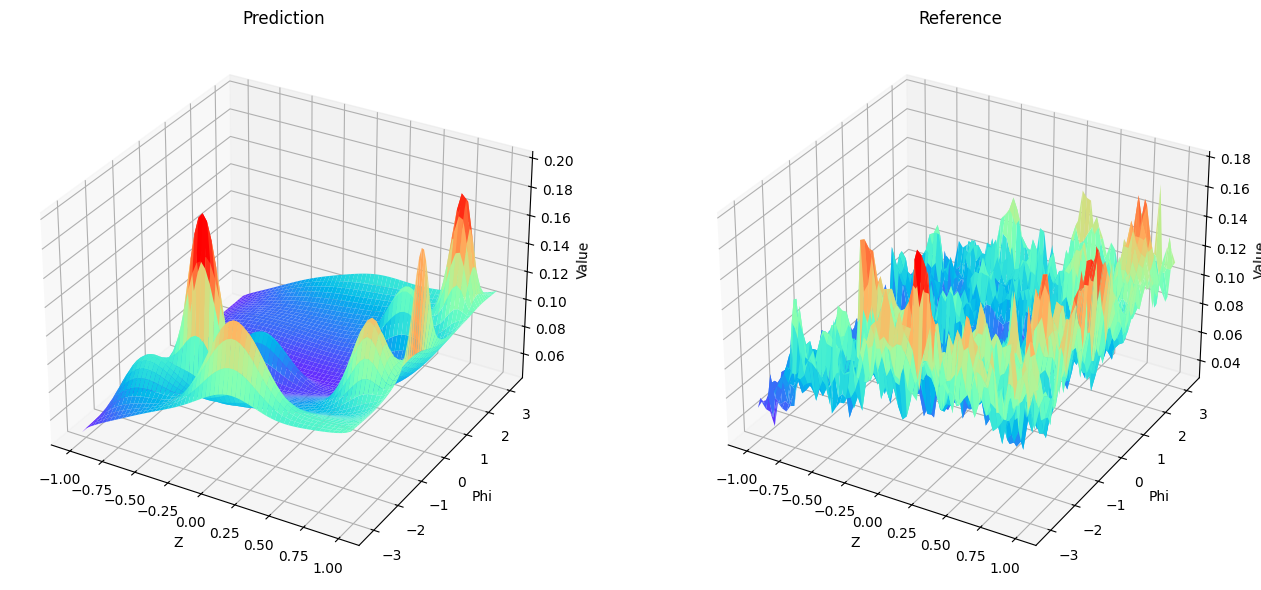

In [12]:
# Predictions
with torch.no_grad():
    vmf.eval()
    weights, axes, kappas = vmf()
    predictions = multi_vmf(weights, axes, kappas, X).cpu().numpy() 
    predictions = predictions.reshape(sizes[0], sizes[1])
    reference = ray_data.cpu().numpy().reshape(sizes[0], sizes[1])
    plot_outputs_3d(reference, predictions, sizes)
    

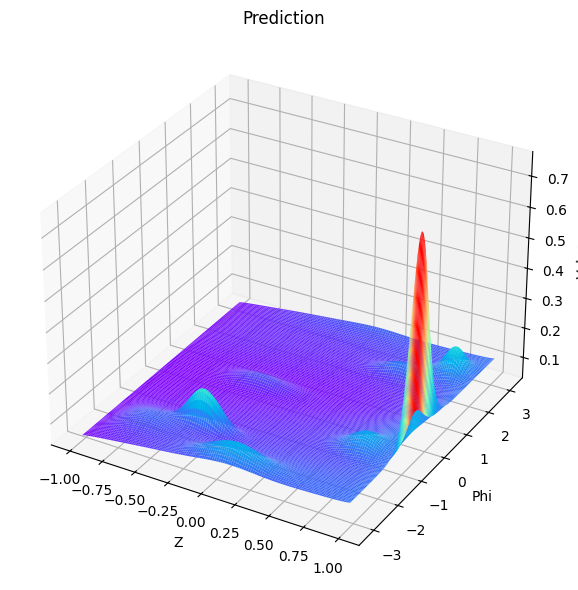

In [13]:
sizes_dense = np.array([128,128])
X_dense = get_gridX(sizes_dense)
with torch.no_grad():
    vmf.eval()
    weights, axes, kappas = vmf()
    predictions = multi_vmf(weights, axes, kappas, X_dense).cpu().numpy() 
    predictions = predictions.reshape(sizes_dense)
    reference = np.zeros_like(predictions)
    plot_outputs_3d(reference, predictions, sizes_dense)

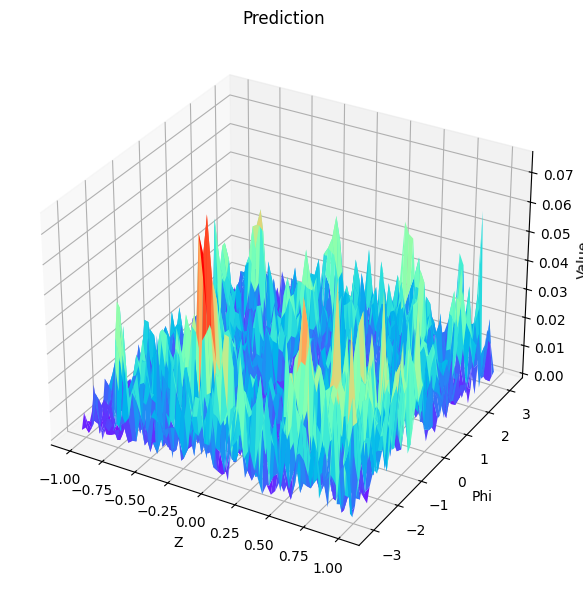

In [14]:
with torch.no_grad():
    vmf.eval()
    weights, axes, kappas = vmf()
    predictions = multi_vmf(weights, axes, kappas, X).cpu().numpy() 
    predictions = predictions.reshape(sizes[0], sizes[1])
    reference = ray_data.cpu().numpy().reshape(sizes[0], sizes[1])
    error = np.abs(predictions - reference)
    zero_e = np.zeros_like(error)
    plot_outputs_3d(zero_e, error, sizes)

In [8]:
# 初始化模型和优化器参数
num_components = 64
num_epochs = 10000
kl_lambda = 1
l1_lambda = 10
l2_lambda = 0.5
learning_rate = 5e-3
weight_decay = 1e-5
sizes = np.array([64, 64])

hyperparams = {
    "kl_lambda":kl_lambda,
    "l1_lambda":l1_lambda,
    "l2_lambda":l2_lambda,
    "num_epochs":num_epochs
}

# 数据文件路径（针对每个模型的不同数据集）

def generate_filenames(base_path, num_files):
    """生成文件路径列表"""
    return [os.path.join(base_path, f"{i}\\rawdataNonSpe.bin") for i in range(1, num_files + 1)]

# 初始化参数
base_path = "D:\\Github\\datasets\\raw_data\\foam0"
num_files = 5  # 从 1 到 14
filenames = generate_filenames(base_path, num_files)
num_models = len(filenames)

cuda_streams = []  # Cuda streamings list
datasets = []  
optimizers = [] 
models = []

for i in range(num_models):
    vmf = vMFMixtureModel(num_components=num_components).to(device)
    optimizer = torch.optim.Adam(vmf.parameters(), lr=learning_rate, weight_decay=weight_decay)
    models.append(vmf)
    optimizers.append(optimizer)

    # 加载对应的数据集
    raw_data, ray_data, X = load_rawdata(filenames[i], sizes, device, verbose=False)
    dataset = {
        "samples": raw_data.clone().detach(),
        "target": ray_data.reshape(-1).to(device),
        "w_data": X.clone().detach()
    }
    datasets.append(dataset)
    cuda_streams.append(torch.cuda.Stream(device=device))


# 确定保存路径（根据每个数据文件夹保存到相应位置）
save_paths = [os.path.dirname(f) for f in filenames]

In [29]:
for i in range(num_models):
    train_model(i, models[i], optimizers[i], datasets[i], hyperparams, device, save_paths[i], verbose=False)

Model 0 parameters saved to D:\Github\datasets\raw_data\foam0\1\vmf_parameters.pth
Model 1 parameters saved to D:\Github\datasets\raw_data\foam0\2\vmf_parameters.pth
Model 2 parameters saved to D:\Github\datasets\raw_data\foam0\3\vmf_parameters.pth
Model 3 parameters saved to D:\Github\datasets\raw_data\foam0\4\vmf_parameters.pth
Model 4 parameters saved to D:\Github\datasets\raw_data\foam0\5\vmf_parameters.pth


In [12]:
# 启动线程进行并行训练
threads = []
for i in range(num_models):
    thread = threading.Thread(
        target=train_model,
        args=(
            i + 1, models[i], optimizers[i],
            datasets[i],
            hyperparams,
            device, save_paths[i],
            cuda_streams[i]
        )
    )
    threads.append(thread)
    thread.start()

# 等待所有线程结束
for thread in threads:
    thread.join()

Model 2 parameters saved to D:\Github\datasets\raw_data\foam0\2\vmf_parameters.pth
Model 4 parameters saved to D:\Github\datasets\raw_data\foam0\4\vmf_parameters.pth
Model 1 parameters saved to D:\Github\datasets\raw_data\foam0\1\vmf_parameters.pth
Model 5 parameters saved to D:\Github\datasets\raw_data\foam0\5\vmf_parameters.pth
Model 3 parameters saved to D:\Github\datasets\raw_data\foam0\3\vmf_parameters.pth


C:\Users\runze\AppData\Local\Temp\ipykernel_25848\921733466.py:291: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

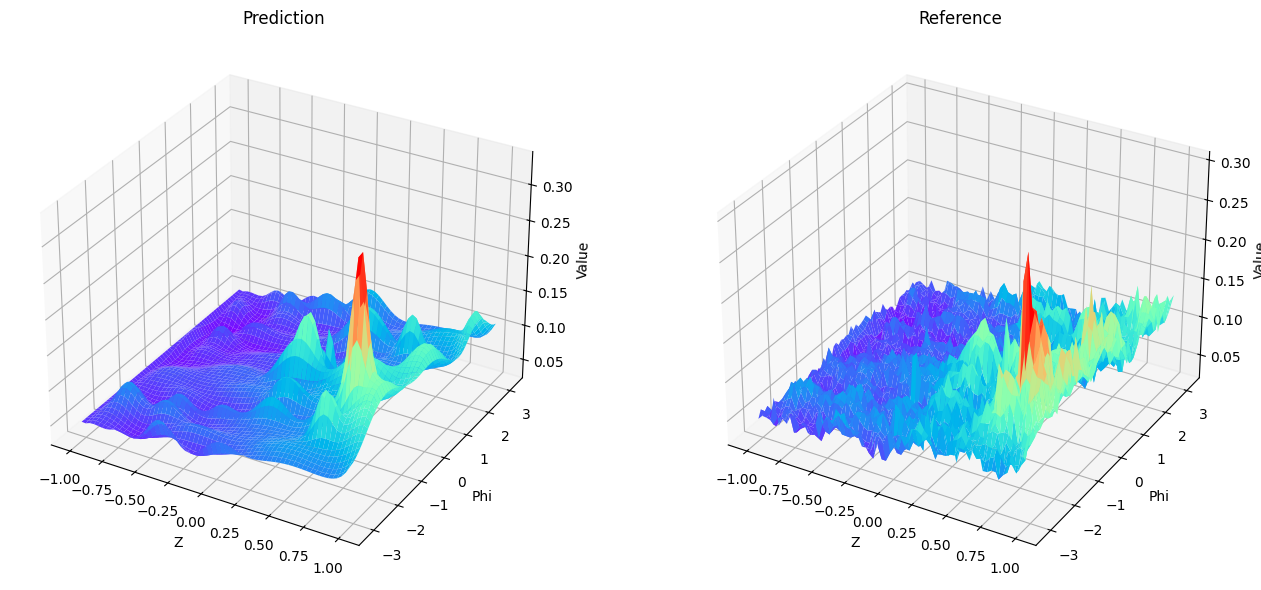

In [9]:
params_path = "D:/Github/datasets/raw_data/foam0/1/vmf_parameters.pth"
model = load_model(params_path, num_components, device).to(device)
with torch.no_grad():
    model.eval()
    weights, axes, kappas = model()
    predictions = multi_vmf(weights, axes, kappas, X).cpu().numpy() 
    predictions = predictions.reshape(sizes[0], sizes[1])
    reference = datasets[0]["target"].cpu().numpy().reshape(sizes[0], sizes[1])
    plot_outputs_3d(reference, predictions, sizes, save_path=None)